In [19]:
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as clr
from matplotlib.colorbar import ColorbarBase
# from matplotlib import gridspec

In [20]:
data_path = "/cronus_data/avirinchipur/ptsd_stop/forecasting/datasets/PCLsubscales_selfreportZ_roberta_laL23rpca64_wtcSubscalesNormalized_merged_PCL_1_days_ahead_reset_time2zero_max90days_v6_60combined_5fold_oots"
dataDict = load_from_disk(data_path)
dataDict

Dataset({
    features: ['seq_id', 'time_ids', 'embeddings_subscales', 'mask_subscales', 'embeddings_lang', 'mask_lang', 'embeddings_wtcSubscales', 'mask_wtcSubscales', 'outcomes', 'outcomes_mask', 'orig_time_ids', 'folds', 'oots_mask', 'embeddings_subscales_z'],
    num_rows: 196
})

## Timeline Plot

In [21]:
num_subscales_days = [(len(i) - sum(i)) for i in dataDict['mask_subscales']]
num_lang_days = [(len(i) - sum(i)) for i in dataDict['mask_lang']]
num_outcomes_days = [np.array(i).sum() for i in dataDict['outcomes_mask']]

In [22]:
np.corrcoef(num_subscales_days, num_lang_days)

array([[1.        , 0.82215204],
       [0.82215204, 1.        ]])

In [23]:
print (np.corrcoef(num_subscales_days, num_outcomes_days))

[[1.         0.99428361]
 [0.99428361 1.        ]]


In [24]:
print (np.corrcoef(num_lang_days, num_outcomes_days))

[[1.         0.82391793]
 [0.82391793 1.        ]]


In [25]:
max_subscale_days, max_lang_days = max(num_subscales_days), max(num_lang_days)
max_days = max(max_subscale_days, max_lang_days)
print (max_subscale_days, max_lang_days, max_days)

90 90 90


In [8]:
subscale_days = []
lang_days = []
outcomes_days = []
for i in range(len(dataDict['mask_subscales'])):
    subscale_days.append(dataDict['mask_subscales'][i] + [1]*(max_days - len(dataDict['mask_subscales'][i])))
    lang_days.append(dataDict['mask_lang'][i] + [1]*(max_days - len(dataDict['mask_lang'][i])))
    outcomes_days.append(np.array(dataDict['outcomes_mask'][i]).reshape(-1, ).tolist() + [0]*(max_days - len(dataDict['outcomes_mask'][i])))

subscale_days = (~np.array(subscale_days, dtype=bool)).astype(int)
lang_days = (~np.array(lang_days, dtype=bool)).astype(int)
outcomes_days = np.array(outcomes_days).astype(int)

print (subscale_days.shape, lang_days.shape, outcomes_days.shape)

(196, 90) (196, 90) (196, 90)


In [9]:
def combine_masks(mask1, mask2):
    combined_masks = []
    assert len(mask1) == len(mask2), "Length of the masks should be the same. Mask 1 length: {}, Mask 2 length: {}".format(len(mask1), len(mask2))
    for i in range(len(mask1)):
        seq_mask = []
        for j in range(len(mask1[i])):
            if mask1[i][j] == 0 and mask2[i][j] == 0:
                seq_mask.append(0)
            elif mask1[i][j] != 0 and mask2[i][j] != 0:
                seq_mask.append(3)
            elif mask1[i][j] != 0 and mask2[i][j] == 0:
                seq_mask.append(1)
            elif mask1[i][j] == 0 and mask2[i][j] != 0:
                seq_mask.append(2)
        combined_masks.append(seq_mask)
    return combined_masks

combined_langSubscales_mask = combine_masks(subscale_days, lang_days)
combined_langOutcomes_mask = combine_masks(lang_days, outcomes_days)
combined_subscalesOutcomes_mask = combine_masks(subscale_days, outcomes_days)
combined_langSubscalesOutcomes_mask = combine_masks(combined_langSubscales_mask, outcomes_days)


In [10]:
sorted_idxs = np.argsort(num_subscales_days)
combined_langSubscalesOutcomes_mask_sorted = np.array(combined_langSubscalesOutcomes_mask)[sorted_idxs][::-1]

In [11]:
clrs = list(map(lambda x: (x[0]/8.0, x[1]), enumerate(['#d73027','#f46d43','#fdae61','#fee08b','#ffffbf','#d9ef8b','#a6d96a','#66bd63','#1a9850'])))
custom_cmap = clr.LinearSegmentedColormap.from_list('custom coolwarm', clrs, N=512)

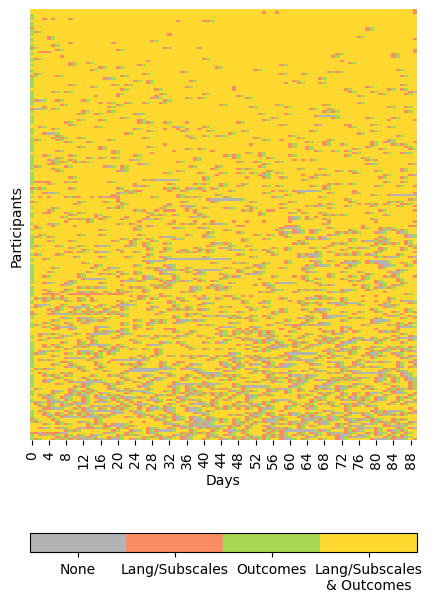

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_langSubscalesOutcomes_mask_sorted, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])
# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Lang/Subscales', 'Outcomes', 'Lang/Subscales\n& Outcomes'])

# Set the x and y labels
ax.set_xlabel('Days')
ax.set_ylabel('Participants')

plt.show()

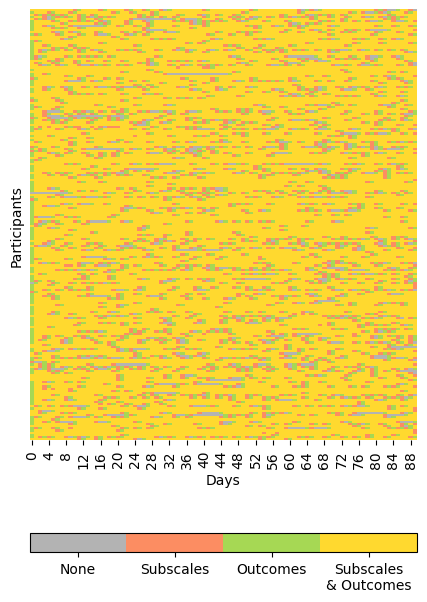

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_subscalesOutcomes_mask, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])

# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Subscales', 'Outcomes', 'Subscales\n& Outcomes'])

# Set the x and y labels
ax.set_xlabel('Days')
ax.set_ylabel('Participants')
plt.show()

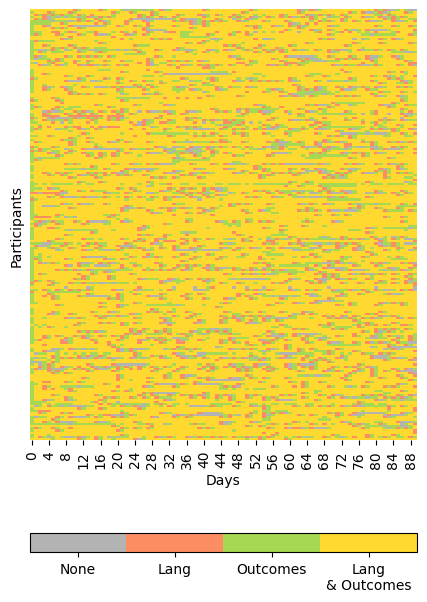

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
# Plot the combined mask on a heatmap
set2_colors = sns.color_palette("Set2").as_hex()
# Choose only 4 colors from the tab20 palette
colors4 = [set2_colors[i] for i in [7, 1, 4, 5]]
custom_cmap = clr.ListedColormap(colors4)
sns.heatmap(combined_langOutcomes_mask, ax=ax, cmap=custom_cmap, cbar=False)
ax.set_yticks([])

# Set the cbar tocks as ['None', 'Outcomes', 'Language/Subscales', 'Outcomes & Language/Subscales']
my_cmap = clr.ListedColormap(colors4)
norm = clr.Normalize(vmin=0, vmax=3)
sm = ScalarMappable(cmap=my_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_ticks([0.75/2, (1.5+0.75)/2, (1.5+2.25)/2, (5.25)/2])
cbar.set_ticklabels(['None', 'Lang', 'Outcomes', 'Lang\n& Outcomes'])

# Set the x and y labels
ax.set_xlabel('Days')
ax.set_ylabel('Participants')
plt.show()

## Data Statistics

In [15]:
# Collect 
# 1. Number of sequences
# 2. Mean and median Number of days with language 
# 3. Mean and median Number of days with subscales
# 4. Mean and median Number of days with outcomes
# 5. Cumulative distribution of the number of days with lang/subscales and outcomes

In [17]:
print ("Number of sequences: ", len(dataDict['mask_subscales']))
print ("Min and Max number of days with language: ", min(num_lang_days), max(num_lang_days))
print ("Mean and median Number of days with language: ", np.mean(num_lang_days), np.median(num_lang_days))
print ("Min and Max number of days with subscales: ", min(num_subscales_days), max(num_subscales_days))
print ("Mean and median Number of days with subscales: ", np.mean(num_subscales_days), np.median(num_subscales_days))
print ("Min and Max number of days with outcomes: ", min(num_outcomes_days), max(num_outcomes_days))
print ("Mean and median Number of days with outcomes: ", np.mean(num_outcomes_days), np.median(num_outcomes_days))

Number of sequences:  196
Min and Max number of days with language:  33 90
Mean and median Number of days with language:  70.07142857142857 72.0
Min and Max number of days with subscales:  48 90
Mean and median Number of days with subscales:  74.91326530612245 77.0
Min and Max number of days with outcomes:  48 90
Mean and median Number of days with outcomes:  75.23469387755102 76.0


In [18]:
# Print total number of language days, subscales days and outcomes days
print ("Total number of language days: ", sum(num_lang_days))
print ("Total number of subscales days: ", sum(num_subscales_days))
print ("Total number of outcomes days: ", sum(num_outcomes_days))

Total number of language days:  13734
Total number of subscales days:  14683
Total number of outcomes days:  14746
